In [1]:
%pwd

'/Users/ruixu/Library/CloudStorage/OneDrive-TheOhioStateUniversity/Rui Xu-Research/Colon cancer mutiomics study 2022F-/Data analysis/4.ANN OCCPI analysis/OCCPI.Tstg'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_csv('/Users/ruixu/Library/CloudStorage/OneDrive-TheOhioStateUniversity/Rui Xu-Research/Colon cancer mutiomics study 2022F-/Data analysis/4.ANN OCCPI analysis/OCCPI.Tstg/OCCPI.Tstg.csv', index_col=0)

In [3]:
df = df.replace([np.inf, -np.inf], np.nan)
cols_to_fillna = df.columns[2:]
df[cols_to_fillna] = df[cols_to_fillna].fillna(df[cols_to_fillna].mean())
#df.drop(df.columns[0], axis=1, inplace=True)
print(df.info())
#print(df.head())

<class 'pandas.core.frame.DataFrame'>
Index: 348 entries, A.416 to A.109
Columns: 241 entries, Tstg to Xanthosine dihydrate
dtypes: float64(240), int64(1)
memory usage: 657.9+ KB
None


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.utils import to_categorical
X = df.iloc[:, 1:]  # 特征
y = df['Tstg']  # 标签
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
print(y_train.shape)
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

2024-03-11 02:13:51.926443: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


(313,)


In [5]:
import keras
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Activation
def build_model(hidden_layers=1, layer_size=30, learning_rate=3e-3,
                activation='relu', regularization=None, reg_strength=1e-4, batch_size=32):
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(layer_size, activation=activation, input_shape=(X_train.shape[1],)))
    
    # 添加正则化
    if regularization is not None:
        if regularization == 'l1':
            reg = keras.regularizers.l1(reg_strength)
        elif regularization == 'l2':
            reg = keras.regularizers.l2(reg_strength)
        else:
            raise ValueError("Invalid regularization type. Choose 'l1' or 'l2'.")
        model.add(keras.layers.Dense(layer_size, activation=activation, kernel_regularizer=reg))
    else:
        model.add(keras.layers.Dense(layer_size, activation=activation))
    
    for _ in range(hidden_layers-1):
        # 添加正则化
        if regularization is not None:
            model.add(keras.layers.Dense(layer_size, activation=activation, kernel_regularizer=reg))
        else:
            model.add(keras.layers.Dense(layer_size, activation=activation))
    
    model.add(keras.layers.Dense(4))
    model.add(Activation('softmax'))
    optimizer = keras.optimizers.SGD(learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model
sklearn_model = keras.wrappers.scikit_learn.KerasClassifier(build_model)

/var/folders/xm/v410f3rx60n6h8209h6jtpww0000gn/T/ipykernel_33635/3544990636.py:33: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  sklearn_model = keras.wrappers.scikit_learn.KerasClassifier(build_model)


2024-03-11 02:13:58.856341: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


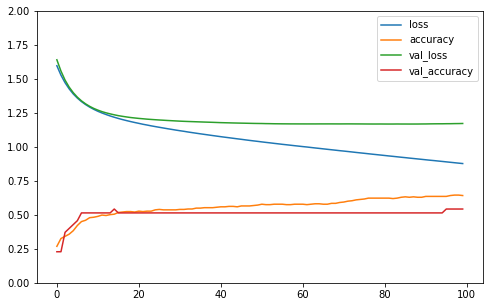

2/2 [==============================] - 0s 5ms/step - loss: 1.1723 - accuracy: 0.5429
Test Accuracy: 0.5428571701049805
2/2 [==============================] - 0s 3ms/step
AUC Scores: [0.49333333 0.71774194 0.56666667 0.77011494]


In [6]:
history1 = sklearn_model.fit(X_train_normalized, y_train_one_hot,
                            epochs = 100,
                            validation_data=(X_test_normalized,y_test_one_hot), 
                            verbose=0)
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(False)  # 关闭网格线
    plt.gca().set_ylim(0,2)
    plt.show()
plot_learning_curves(history1)
test_accuracy = sklearn_model.score(X_test_normalized, y_test_one_hot)
print("Test Accuracy:", test_accuracy)
from sklearn.metrics import roc_auc_score
y_pred_prob = sklearn_model.predict_proba(X_test_normalized)
auc_scores = roc_auc_score(y_test_one_hot, y_pred_prob, average=None)
print("AUC Scores:", auc_scores)

In [7]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribution = {
    'hidden_layers': [1, 2, 3, 4, 5],
    'layer_size': np.arange(1, 128),  
    'learning_rate': reciprocal(1e-4, 1e-2),
    'activation': ['relu', 'tanh'],  
    'regularization': [None, 'l1', 'l2'],  # 正则化的选择范围
    'reg_strength': reciprocal(1e-6, 1),  # 正则化强度的选择范围
    'batch_size': [16, 32, 64, 128]  
}
# 创建神经网络模型
random_search_cv = RandomizedSearchCV(sklearn_model,
                                     param_distribution,
                                     n_iter = 10,
                                     cv =5,
                                     n_jobs =1)

random_search_cv.fit(X_train_normalized, y_train_one_hot, epochs = 10,
                    validation_data = (X_test_normalized, y_test_one_hot),
                    verbose=0)

print(f'Best parameters: {random_search_cv.best_params_}')
print(f'Best cross-validation score: {random_search_cv.best_score_}')

2/2 [==============================] - 0s 5ms/step - loss: 1.4132 - accuracy: 0.2581
Best parameters: {'activation': 'relu', 'batch_size': 32, 'hidden_layers': 5, 'layer_size': 14, 'learning_rate': 0.0008631818145675562, 'reg_strength': 0.0009831128763592223, 'regularization': None}
Best cross-validation score: 0.4409114241600037


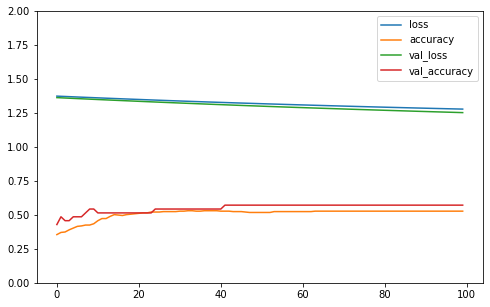

2/2 [==============================] - 0s 7ms/step - loss: 1.2523 - accuracy: 0.5714


[1.2522659301757812, 0.5714285969734192]

In [8]:
best_model = random_search_cv.best_estimator_.model
history2 = best_model.fit(X_train_normalized, y_train_one_hot,
                                 epochs=100,
                                 validation_data=(X_test_normalized, y_test_one_hot),
                                 verbose=0)
plot_learning_curves(history2)
best_model.evaluate(X_test_normalized,y_test_one_hot)

In [9]:
#using all features to optimize the parameter
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model, Sequential
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense

def build_encoder(encoding_dim=2):
    # Define the encoder model
    input_dim = X_train_normalized.shape[1]
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(encoding_dim, activation='relu')(input_layer)
    encoder = Model(input_layer, encoded)

    # Compile the encoder model
    encoder.compile(optimizer='adam', loss='mse')
    return encoder


In [10]:
def build_model_after_encoder(hidden_layers=random_search_cv.best_params_['hidden_layers'], 
                              layer_size = random_search_cv.best_params_['layer_size'],
                              learning_rate = random_search_cv.best_params_['learning_rate'],
                              activation = random_search_cv.best_params_['activation'],
                              regularization = random_search_cv.best_params_['regularization'],
                              reg_strength = random_search_cv.best_params_['reg_strength'],
                              batch_size = random_search_cv.best_params_['batch_size']):
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(layer_size, activation=activation))
    
    # 添加正则化
    if regularization is not None:
        if regularization == 'l1':
            reg = keras.regularizers.l1(reg_strength)
        elif regularization == 'l2':
            reg = keras.regularizers.l2(reg_strength)
        else:
            raise ValueError("Invalid regularization type. Choose 'l1' or 'l2'.")
        model.add(keras.layers.Dense(layer_size, activation=activation, kernel_regularizer=reg))
    else:
        model.add(keras.layers.Dense(layer_size, activation=activation))
    
    for _ in range(hidden_layers-1):
        # 添加正则化
        if regularization is not None:
            model.add(keras.layers.Dense(layer_size, activation=activation, kernel_regularizer=reg))
        else:
            model.add(keras.layers.Dense(layer_size, activation=activation))
    
    model.add(keras.layers.Dense(4))
    model.add(keras.layers.Activation('softmax'))
    optimizer = keras.optimizers.SGD(learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model
sklearn_model = KerasClassifier(build_fn=build_model_after_encoder)
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import numpy as np

best_test_accuracy = 0
best_encoding_dim = None
best_loss = float('inf')
best_history = None
best_model = None

# 循环遍历编码维度
for encoding_dim in range(2, 11):
    encoder_model = build_encoder(encoding_dim)
    #dummy_target = np.zeros((X_train_normalized.shape[0], encoding_dim))
    #encoder_model.fit(X_train_normalized, dummy_target)
    X_train_encoded = encoder_model.predict(X_train_normalized)
    X_test_encoded = encoder_model.predict(X_test_normalized)
    history = sklearn_model.fit(X_train_encoded, y_train_one_hot,
                            epochs=100,
                            validation_data=(X_test_encoded, y_test_one_hot),
                            verbose=0)

    test_accuracy = history.history['accuracy'][-1]
    test_loss = history.history['loss'][-1]
    print(f"Encoding Dim: {encoding_dim}, loss:{test_loss},Test Accuracy: {test_accuracy}")
    
    if test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy
        best_encoding_dim = encoding_dim
        best_loss = test_loss
        best_history = history
        best_model = sklearn_model

print(f"Best Encoding Dim: {best_encoding_dim}, Best Test Accuracy: {best_test_accuracy}")
history3 = best_history
sklearn_model3=best_model

10/10 [==============================] - 0s 2ms/step


/var/folders/xm/v410f3rx60n6h8209h6jtpww0000gn/T/ipykernel_33635/864461113.py:35: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  sklearn_model = KerasClassifier(build_fn=build_model_after_encoder)


2/2 [==============================] - 0s 3ms/step
Encoding Dim: 2, loss:1.2830570936203003,Test Accuracy: 0.5239616632461548
2/2 [==============================] - 0s 3ms/step
Encoding Dim: 3, loss:1.2917557954788208,Test Accuracy: 0.5271565318107605
2/2 [==============================] - 0s 3ms/step
Encoding Dim: 4, loss:1.2873687744140625,Test Accuracy: 0.5271565318107605
2/2 [==============================] - 0s 2ms/step
Encoding Dim: 5, loss:1.2591352462768555,Test Accuracy: 0.5271565318107605
2/2 [==============================] - 0s 3ms/step
Encoding Dim: 6, loss:1.2691808938980103,Test Accuracy: 0.5271565318107605
2/2 [==============================] - 0s 2ms/step
Encoding Dim: 7, loss:1.283453106880188,Test Accuracy: 0.5271565318107605
2/2 [==============================] - 0s 3ms/step
Encoding Dim: 8, loss:1.2776095867156982,Test Accuracy: 0.5271565318107605
2/2 [==============================] - 0s 2ms/step
Encoding Dim: 9, loss:1.236862063407898,Test Accuracy: 0.52715653181

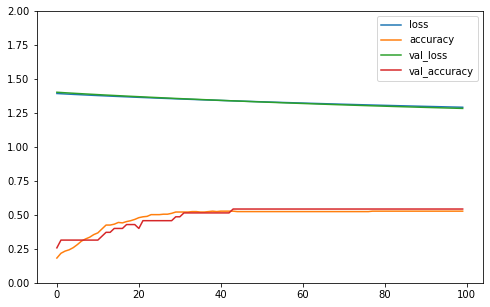

2/2 [==============================] - 0s 6ms/step - loss: 1.1545 - accuracy: 0.5714
Test Accuracy: 0.5271565318107605


In [11]:
plot_learning_curves(history3)
test_accuracy = sklearn_model3.score(X_test_encoded, y_test_one_hot)
print("Test Accuracy:", best_test_accuracy)

In [12]:
df1 = pd.read_csv('/Users/ruixu/Library/CloudStorage/OneDrive-TheOhioStateUniversity/Rui Xu-Research/Colon cancer mutiomics study 2022F-/Data analysis/4.ANN OCCPI analysis/OCCPI.Tstg/plsda_score.csv', index_col=0)

In [13]:
df1 = df1.replace([np.inf, -np.inf], np.nan)
cols_to_fillna = df1.columns[2:]
df1[cols_to_fillna] = df1[cols_to_fillna].fillna(df1[cols_to_fillna].mean())
print(df1.info())

<class 'pandas.core.frame.DataFrame'>
Index: 348 entries, A.1 to A.99
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Tstg    348 non-null    int64  
 1   Comp 1  348 non-null    float64
 2   Comp 2  348 non-null    float64
 3   Comp 3  348 non-null    float64
 4   Comp 4  348 non-null    float64
 5   Comp 5  348 non-null    float64
 6   Comp 6  348 non-null    float64
 7   Comp 7  348 non-null    float64
 8   Comp 8  348 non-null    float64
dtypes: float64(8), int64(1)
memory usage: 27.2+ KB
None


In [14]:
X1 = df1.iloc[:, 1:]  # 特征
y1 = df1['Tstg']  # 标签
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.1, random_state=42)
print(y1_train.shape)
scaler = StandardScaler()
X1_train_normalized = scaler.fit_transform(X1_train)
X1_test_normalized = scaler.transform(X1_test)
y1_train_one_hot = to_categorical(y1_train)
y1_test_one_hot = to_categorical(y1_test)

(313,)


/var/folders/xm/v410f3rx60n6h8209h6jtpww0000gn/T/ipykernel_33635/2715415626.py:36: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  sklearn_model4 = KerasClassifier(build_fn=build_model, input_shape=(X1_train_normalized.shape[1],),


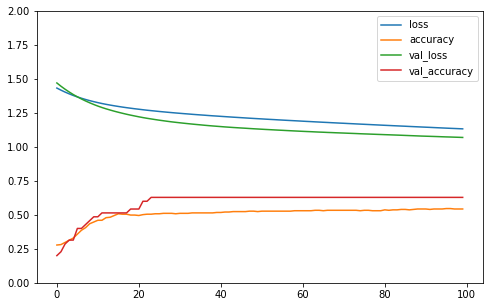

Test Accuracy: 0.6285714507102966


In [15]:
# 修改 build_model 函数，添加 input_shape 参数
import keras
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Activation
def build_model(input_shape, hidden_layers=1, layer_size=30, learning_rate=3e-3,
                activation='relu', regularization=None, reg_strength=1e-4, batch_size=32):
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(layer_size, activation=activation, input_shape=input_shape))
    
    # 添加正则化
    if regularization is not None:
        if regularization == 'l1':
            reg = keras.regularizers.l1(reg_strength)
        elif regularization == 'l2':
            reg = keras.regularizers.l2(reg_strength)
        else:
            raise ValueError("Invalid regularization type. Choose 'l1' or 'l2'.")
        model.add(keras.layers.Dense(layer_size, activation=activation, kernel_regularizer=reg))
    else:
        model.add(keras.layers.Dense(layer_size, activation=activation))
    
    for _ in range(hidden_layers-1):
        # 添加正则化
        if regularization is not None:
            model.add(keras.layers.Dense(layer_size, activation=activation, kernel_regularizer=reg))
        else:
            model.add(keras.layers.Dense(layer_size, activation=activation))
    
    model.add(keras.layers.Dense(4))
    model.add(Activation('softmax'))
    optimizer = keras.optimizers.SGD(learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# 创建 KerasClassifier 实例时传递 input_shape 参数
sklearn_model4 = KerasClassifier(build_fn=build_model, input_shape=(X1_train_normalized.shape[1],),
                                  epochs=100, batch_size=32, verbose=0)

# 训练模型
history4 = sklearn_model4.fit(X1_train_normalized, y1_train_one_hot, validation_data=(X1_test_normalized, y1_test_one_hot))


test_accuracy = sklearn_model4.score(X1_test_normalized, y1_test_one_hot)

# 绘制学习曲线
plot_learning_curves(history4)
print("Test Accuracy:", test_accuracy)


In [16]:
from keras.models import Model
from keras.utils.vis_utils import plot_model

# 获取Keras模型对象
keras_model = sklearn_model3.build_fn(**sklearn_model3.filter_sk_params(sklearn_model3.build_fn))

# 可视化模型结构并保存为图片
plot_model(keras_model, to_file='model_structure.png', show_shapes=True, show_layer_names=True)


ValueError: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data.